In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import math

import utils
import train_infer_utils
from model import UNet
from config import Config
from consts import Consts

In [20]:
trans = transforms.ToTensor()
reverse_trans = transforms.ToPILImage()
train_set = datasets.MNIST(
    "data", train=True, download=True, transform=trans
)
test_set = datasets.MNIST(
    "data", train=False, download=True, transform=trans
)

In [21]:
train_loader = DataLoader(
    train_set, batch_size=Config.batch_size, shuffle=True, num_workers=4, drop_last=True
)

test_loader = DataLoader(
    test_set, batch_size=Config.batch_size, shuffle=True, num_workers=4, drop_last=True
)

print(len(train_set))

60000


torch.Size([64, 1, 28, 28])
(28, 28)


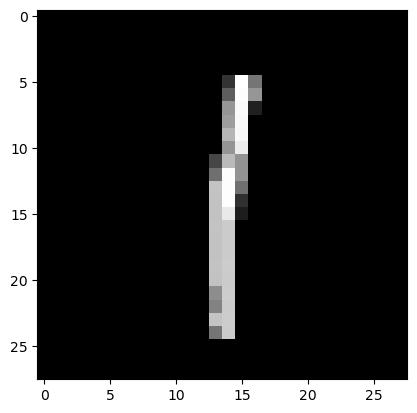

In [22]:
for (X, y) in train_loader:
    print(X.size())
    X = X[0]

    img = reverse_trans(X)
    print(img.size)
    plt.imshow(img, cmap='gray')
    break

In [23]:
for (X, y) in train_loader:
    X = X[0]
    print(X.shape)
    imgs = [train_infer_utils.get_noisy_image(X, torch.tensor([t])) for t in [0, 50, 100, 150, 199]]
    imgs = list(map(lambda img : reverse_trans(img), imgs))
    print(imgs[0].size)
    utils.plot(imgs, cmap ='gray')
    break

torch.Size([1, 28, 28])
(28, 28)


In [24]:
model = UNet(Config.channels, Config.channels, Config.time_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

UNet(
  (time_embedding): TimeEmbedding(
    (time_embedding): Sequential(
      (0): Linear(in_features=28, out_features=112, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=112, out_features=112, bias=True)
    )
  )
  (in_conv): InConv(
    (in_conv): ResidualDoubleConvBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv2): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (mlp): Sequential(
        (0): SiLU()
        (1): Linear(in_features=112, out_features=64, bias=True)
      )
      (res

In [25]:
sum_img = 0
torch.autograd.set_detect_anomaly(True)
for epoch in range(Config.epochs):
    for (X, y) in train_loader:
        optimizer.zero_grad()
        X = X.to(device)

        step = torch.randint(0, Config.timesteps, (Config.batch_size,), device=device)
        loss = train_infer_utils.diff_loss(X, step, model)

        loss.backward()
        optimizer.step()

        sum_img += Config.batch_size
        print(f"{sum_img : 7d} : {loss.item() * 100 : .3f}%")
        # if sum_img >= 100000:
        #     break

     64 :  48.771%
    128 :  19.633%
    192 :  15.516%
    256 :  11.806%
    320 :  11.326%
    384 :  9.439%
    448 :  11.934%
    512 :  8.669%
    576 :  8.057%
    640 :  6.918%
    704 :  6.630%
    768 :  7.117%
    832 :  7.891%
    896 :  6.463%
    960 :  5.531%
   1024 :  6.266%
   1088 :  5.558%
   1152 :  6.036%
   1216 :  5.283%
   1280 :  5.419%
   1344 :  5.739%
   1408 :  6.405%
   1472 :  6.857%
   1536 :  5.631%
   1600 :  5.741%
   1664 :  5.114%
   1728 :  5.527%
   1792 :  5.617%
   1856 :  4.492%
   1920 :  5.573%
   1984 :  6.119%
   2048 :  5.222%
   2112 :  4.499%
   2176 :  4.940%
   2240 :  4.022%
   2304 :  5.410%
   2368 :  3.983%
   2432 :  3.934%
   2496 :  4.326%
   2560 :  4.524%
   2624 :  5.111%
   2688 :  6.357%
   2752 :  4.590%
   2816 :  4.710%
   2880 :  5.338%
   2944 :  5.812%
   3008 :  3.794%
   3072 :  3.907%
   3136 :  7.054%
   3200 :  4.019%
   3264 :  4.561%
   3328 :  4.763%
   3392 :  3.831%
   3456 :  4.487%
   3520 :  3.907%
   3

In [26]:
torch.save(model.state_dict(), Config.model_path)